# Tutorial on DER Hosting Capacity | <font color=red>Part 0</font>: Using dss_python

## 1. Introduction 

### Objectives 
The objectives of this tutorial are:
1. To familiarise with advanced tools useful to run distribution network studies involving DER. You will be using the programming language Python and the advanced distribution network analysis tool [OpenDSS](https://www.epri.com/pages/sa/opendss), an open source tool developed by the [Electric Power Research Institute (EPRI)](https://www.epri.com) in the US. OpenDSS will be used here entirely with Python code thanks to the [dss_python](https://github.com/dss-extensions/dss_python) module developed by researchers at the [University of Campinas](https://www.unicamp.br/unicamp/) in Brazil. And, to guide you, all will be done using a notebook on [Jupyter Notebook](https://jupyter.org/).

2. To interact with the **dss_python module** and show how it replaces using OpenDSS via the COM interface. This module makes simulations and the handling of data/results much faster as everything will be native to Python.

<font color='red'>**<u>Note</u>:**</font> The use of dss_python implies you will be using (and, therefore, you will be limited to) the embedded models and control functions of OpenDSS for particular elements. For instance, you can use OpenDSS's Volt-Watt function for solar PV systems. But you will not be able to modify it to do simultaneous Volt-Watt and Volt-var. If you need to create specific functionalities in Python, then you will need to interact with OpenDSS via the COM interface (which can also be done using Python).


### Structure of this Notebook
The rest of this notebook is divided into two parts:

- **2. Tutorial.** Here you will learn, step by step, how to model a distribution network and analyse what-if scenarios by running power flows with OpenDSS and Python.
- **3. Simulation Workspace.** Here you can place all your code to run it at once.

## 2. Tutorial
### 2.1 Check both libraries are installed
#### Initialise OpenDSS object via COM interface

In [1]:
import win32com.client
dss_via_com = win32com.client.gencache.EnsureDispatch('OpendssEngine.dss') # uses early binding
print(dss_via_com) # check objective type

<win32com.gen_py.OpenDSS Engine.IDSS instance at 0x1803935730224>


#### OpenDSS objective via dss_direct library

In [2]:
import dss
dss_via_python = dss.DSS
print(dss_via_python) # check objective type

#### Time library to calculate the times

In [3]:
import time

### 2.2 Create simple network
#### 2.2.1 Initialise data for the network

In [4]:
import os
text_commands = [
    'clear',
    'set DefaultBaseFrequency=50',
    'new circuit.test_lv_feeder bus1=slack basekv=0.4 pu=1.0 angle=0 frequency=50 phases=3',    
    'new line.slack-B1 phases=3 bus1=slack bus2=B1 r1=0.1 x1=0.1 r0=0.05 x0=0.05 length=1',
    'new line.B1-B2 phases=3 bus1=B1 bus2=B2 r1=0.1 x1=0.1 r0=0.05 x0=0.05 length=1',
    'new line.B2-B3 phases=3 bus1=B2 bus2=B3 r1=0.1 x1=0.1 r0=0.05 x0=0.05 length=1',
    'new loadshape.demand npts=24 interval=1.0 mult={1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 5.0, 7.0, 7.0, 5.0, 3.0, 1.0, 1.0,}',
    'new loadshape.solar  npts=24 interval=1.0 mult={0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 1.0, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,}',   
    'new load.house phases=1 bus1=B3.1 kv=0.23 kw=1 kvar=0 vmaxpu=1.5 vminpu=0.8 daily=demand',
    'new generator.pv_system phases=1 bus1=B3.2 kv=0.23 kw=5 pf=1 vmaxpu=1.5 vminpu=0.8 daily=solar',
    'reset',
    'set ControlMode=Time',
    'set Mode=Daily StepSize=1h Number=1 Time=(0,0)',
    'set VoltageBases=[0.4]',
    'calcv',    
]

#### 2.2.2 Create network in dss_via_com & run simulation

In [5]:
start_com = time.time()   # to capture the starting time dss via com
# only run this once
dss_via_com.Start(0)
dss_via_com.AllowForms = True

In [6]:
for cmd in text_commands:
    dss_via_com.Text.Command = cmd
    
p_pv_system_com = [0 for t in range(24)]
v_pv_system_com = [0 for t in range(24)]
p_house_com = [0 for t in range(24)]
v_house_com = [0 for t in range(24)]
for t in range(24):
    dss_via_com.ActiveCircuit.Solution.Solve()
    
    dss_via_com.ActiveCircuit.SetActiveElement('load.house')
    p_house_com[t] = dss_via_com.ActiveCircuit.ActiveElement.Powers[0]
    v_house_com[t] = dss_via_com.ActiveCircuit.ActiveElement.VoltagesMagAng[0]
    
    dss_via_com.ActiveCircuit.SetActiveElement('generator.pv_system')
    p_pv_system_com[t] = dss_via_com.ActiveCircuit.ActiveElement.Powers[0]
    v_pv_system_com[t] = dss_via_com.ActiveCircuit.ActiveElement.VoltagesMagAng[0]

end_com = time.time() # to capture the ending time dss via com

#### Plot results
* Note: If you copy the code to Python, the %matplotlib inline code will not work. Replace that line with the following lines:
 * from IPython import get_ipython
 * get_ipython().run_line_magic('matplotlib', 'inline')

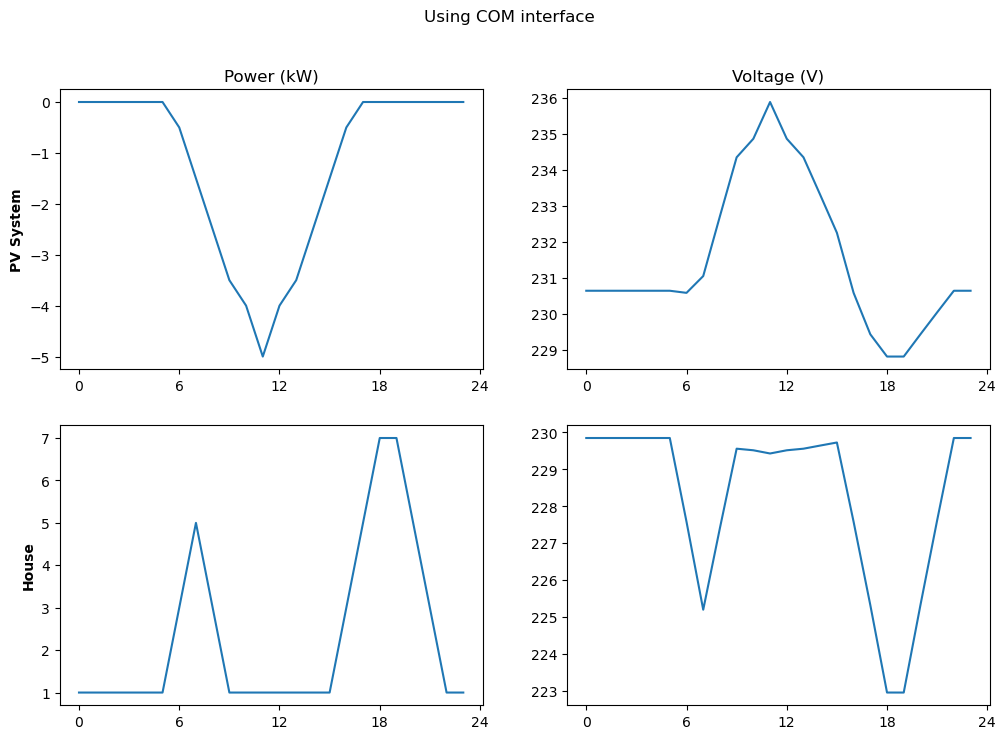

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
plt.suptitle('Using COM interface')
plt.subplot(2,2,1)
plt.plot(p_pv_system_com)
plt.title('Power (kW)')
plt.ylabel('PV System', fontweight='bold')
plt.xticks([0,6,12,18,24])
plt.subplot(2,2,2)
plt.plot(v_pv_system_com)
plt.title('Voltage (V)')
plt.xticks([0,6,12,18,24])
plt.subplot(2,2,3)
plt.plot(p_house_com)
plt.ylabel('House', fontweight='bold')
plt.xticks([0,6,12,18,24])
plt.subplot(2,2,4)
plt.plot(v_house_com)
plt.xticks([0,6,12,18,24])
plt.show()

#### 2.2.3 Repeat the same in dss_via_python
* Note 1: If you copy the code to Python, remember to copy first the code from points 1.2 and 2.1.
* Note 2: .AllowForms will not work in dss_python.

In [8]:
start_dss = time.time()  # to capture the starting time for dss via python
dss_via_python.Start(0)
# dss_via_python.AllowForms = True # this line will not run, try un-comment and run again

for cmd in text_commands:
    dss_via_python.Text.Command = cmd
    
p_pv_system_python = [0 for t in range(24)]
v_pv_system_python = [0 for t in range(24)]
p_house_python = [0 for t in range(24)]
v_house_python = [0 for t in range(24)]

for t in range(24):
    dss_via_python.ActiveCircuit.Solution.Solve()
    
    dss_via_python.ActiveCircuit.SetActiveElement('load.house')
    p_house_python[t] = dss_via_python.ActiveCircuit.ActiveElement.Powers[0]
    v_house_python[t] = dss_via_python.ActiveCircuit.ActiveElement.VoltagesMagAng[0]
    
    dss_via_python.ActiveCircuit.SetActiveElement('generator.pv_system')
    p_pv_system_python[t] = dss_via_python.ActiveCircuit.ActiveElement.Powers[0]
    v_pv_system_python[t] = dss_via_python.ActiveCircuit.ActiveElement.VoltagesMagAng[0]
    
end_dss = time.time()  # to capture the ending time for dss via python

#### Plot results again, should match perfectly with the one above
* Note: If you copy the code to Python, the %matplotlib inline code will not work. Replace that line with the following lines:
 * from IPython import get_ipython
 * get_ipython().run_line_magic('matplotlib', 'inline')

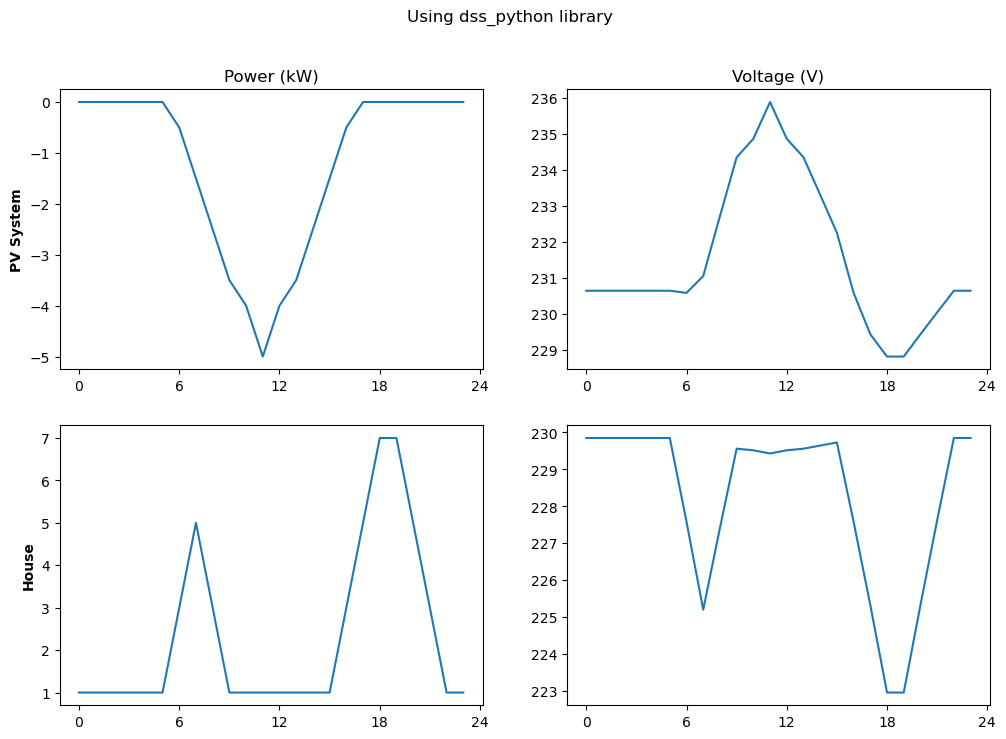

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
plt.suptitle('Using dss_python library')
plt.subplot(2,2,1)
plt.plot(p_pv_system_python)
plt.title('Power (kW)')
plt.ylabel('PV System', fontweight='bold')
plt.xticks([0,6,12,18,24])
plt.subplot(2,2,2)
plt.plot(v_pv_system_python)
plt.title('Voltage (V)')
plt.xticks([0,6,12,18,24])
plt.subplot(2,2,3)
plt.plot(p_house_python)
plt.ylabel('House', fontweight='bold')
plt.xticks([0,6,12,18,24])
plt.subplot(2,2,4)
plt.plot(v_house_python)
plt.xticks([0,6,12,18,24])
plt.show()

#### 2.2.4 Check numerical differences

In [10]:
import numpy as np
np.set_printoptions(suppress=True)

In [11]:
print(np.array(v_pv_system_com) - np.array(v_pv_system_python))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
print(np.array(v_house_com) - np.array(v_house_python))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
print(end_com-start_com, 'seconds')

0.03297305107116699 seconds


In [14]:
print(end_dss-start_dss, 'seconds')

0.0010547637939453125 seconds


Comparing simulation times, running the DSS via Python generally offers faster execution than running DSS via the COM interface and this time saving is advantageous when conducting larger simulations.

## 3. Simulation Workspace